In [1]:
# =====================================================================
#### Task 3: Customer Segmentation
# =====================================================================
### Objective:
#   - Segment customers based on purchasing behavior using RFM metrics:
#       Recency (days since last purchase),
#       Frequency (number of purchases),
#       Monetary (total spend).
#   - Apply KMeans clustering after preprocessing.
#   - Visualize clusters and interpret segment profiles.
### Tools Used:
#   - Python, pandas, numpy, matplotlib, seaborn
#   - Scikit-learn: StandardScaler, KMeans

In [2]:
## Importing the nessessary libraries

# Data handling and manipulation
import pandas as pd
import numpy as np

# Data plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Standardizing features by removing mean and scaling to unit variance
from sklearn.preprocessing import StandardScaler

# Performing K-Means clustering to group similar data points
from sklearn.cluster import KMeans

In [3]:
# Load the dataset from URL
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"
df = pd.read_excel(url)  # Read Excel file

In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
df.shape

(541909, 8)

In [13]:
# Checking which columns have nulls in them
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [19]:
# Remove rows where CustomerID is missing
df = df.dropna(subset=['CustomerID'])

# Remove rows with negative or zero quantity (cancellations/returns)
df = df[df['Quantity'] > 0]

# Calculate total price for each row
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Set analysis date as 1 day after latest invoice
latest_date = df['InvoiceDate'].max()
analysis_date = latest_date + pd.Timedelta(days=1)

In [21]:
# Group by CustomerID to create RFM features
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (analysis_date - x.max()).days,  # Recency: days since last purchase
    'InvoiceNo': 'count',                                     # Frequency: total orders
    'TotalPrice': 'sum'                                       # Monetary: total money spent
})

In [22]:
# Rename columns for clarity
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Remove customers who spent zero
rfm = rfm[rfm['Monetary'] > 0]

In [23]:
rfm.shape

(4338, 3)

In [24]:
# Scale RFM values for clustering
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)  # Normalize data

# Convert scaled data back to DataFrame
rfm_scaled = pd.DataFrame(rfm_scaled, index=rfm.index, columns=rfm.columns)

In [25]:
# Find best number of clusters using elbow method
sse = []  # List to store SSE for each k
k_range = range(1, 11)

In [26]:
# Create KMean model
for k in k_range:
    model = KMeans(n_clusters=k, random_state=42)  
    model.fit(rfm_scaled)                          
    sse.append(model.inertia_)

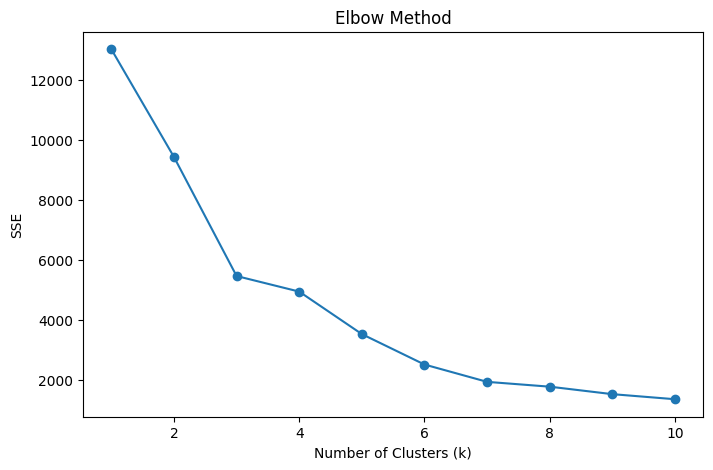

In [27]:
# Plot elbow graph
plt.figure(figsize=(8,5))
plt.plot(k_range, sse, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SSE')
plt.show()

In [29]:
# Choose k=4 based on elbow plot
k = 4
model = KMeans(n_clusters=k, random_state=42)
cluster_labels = model.fit_predict(rfm_scaled)

# Add cluster column to RFM table
rfm['Cluster'] = cluster_labels

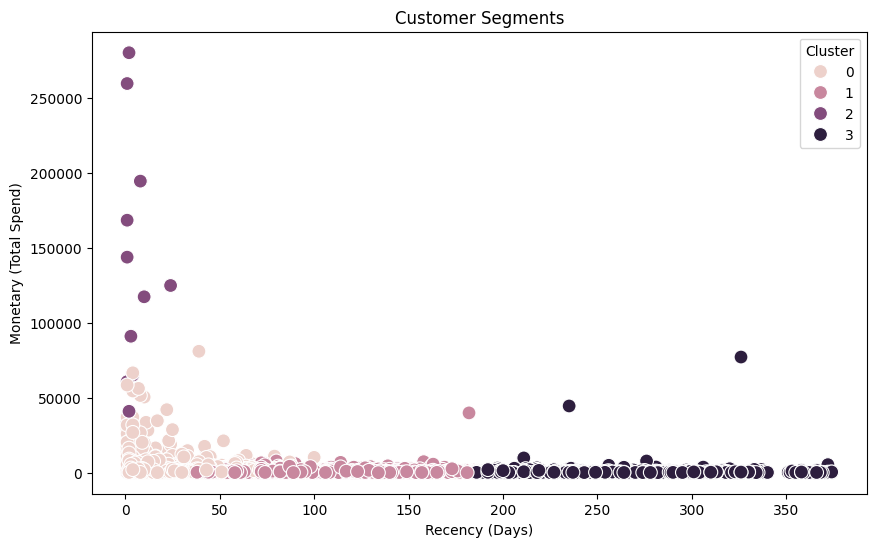

In [30]:
# Plot clusters: Recency vs Monetary
plt.figure(figsize=(10,6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', s=100)
plt.title('Customer Segments')
plt.xlabel('Recency (Days)')
plt.ylabel('Monetary (Total Spend)')
plt.legend(title='Cluster')
plt.show()

In [31]:
# Show average values per cluster
summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Cluster': 'count' 
}).rename(columns={'Cluster': 'Count'})

In [32]:
# Round numbers for readability
summary = summary.round(2)
print("\nCluster Summary:")
print(summary)


Cluster Summary:
         Recency  Frequency   Monetary  Count
Cluster                                      
0          20.99     135.30    2645.82   2171
1          98.22      37.72     773.88   1326
2           4.69    2566.00  126118.31     13
3         272.41      25.14     605.84    828


In [33]:
# Assign friendly names to clusters (based on typical patterns)
cluster_names = {
    0: 'Fans',
    1: 'Lost Customers',
    2: 'Potential Loyalists',
    3: 'Active Spenders'
}

In [34]:
# Add segment names to table
rfm['Segment'] = rfm['Cluster'].map(cluster_names)

In [35]:
print(rfm[['Recency', 'Frequency', 'Monetary', 'Cluster', 'Segment']].head(10))

            Recency  Frequency  Monetary  Cluster          Segment
CustomerID                                                        
12346.0         326          1  77183.60        3  Active Spenders
12347.0           2        182   4310.00        0             Fans
12348.0          75         31   1797.24        1   Lost Customers
12349.0          19         73   1757.55        0             Fans
12350.0         310         17    334.40        3  Active Spenders
12352.0          36         85   2506.04        0             Fans
12353.0         204          4     89.00        3  Active Spenders
12354.0         232         58   1079.40        3  Active Spenders
12355.0         214         13    459.40        3  Active Spenders
12356.0          23         59   2811.43        0             Fans
